## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
import xgboost
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
cor_cols = [x for x in raw_df.columns if 'target_sum' not in x]
raw_df = raw_df.loc[:, cor_cols]

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [5]:
raw_df.currency.value_counts().head()

810    477644
978      5536
840      1921
933       561
985       423
Name: currency, dtype: int64

In [6]:
# основных валюты - три: рубль, евро, доллар США. Нужно перевести amount в рубли и зафильтровать дата фрейм
currency_list = raw_df.currency.value_counts().head(3).index.tolist()
currency_list

[810, 978, 840]

In [7]:
def currency_recode (row):
    if row['currency'] == 810:
        res = row['amount']
    elif row['currency'] == 978:
        res = row['amount']*75.38
    elif row['currency'] == 840:
        res = row['amount']*65.45
    else:
        res = 0
    return res

In [8]:
raw_df = raw_df[raw_df['currency'].isin(currency_list)]
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [9]:
raw_df['amount_corr'] = raw_df.apply(currency_recode, axis=1)

In [10]:
cor_cols = [x for x in raw_df.columns if x != 'amount' and x != 'currency']

In [11]:
raw_df = raw_df.loc[: , cor_cols]

In [12]:
raw_df['amount'] = raw_df['amount_corr'] 

In [13]:
cor_cols = [x for x in raw_df.columns if x != 'amount_corr']

In [14]:
raw_df = raw_df.loc[: , cor_cols]

In [15]:
# развернуть платежи по категориям
categories = raw_df.trx_category.value_counts().head(7).index.tolist()
raw_df = raw_df[raw_df['trx_category'].isin(categories)]

In [16]:
raw_df.channel_type.fillna('na').value_counts()

type1    294174
type2    171113
type5      5483
type4      4393
type3      3184
na         2876
Name: channel_type, dtype: int64

In [17]:
raw_df.describe()

,cl_id,MCC,target_flag,amount
count,481223.000000,481223.000000,481223.000000,4.812230e+05
mean,4812.465495,5702.090216,0.651311,5.383300e+03
std,2988.390541,658.603045,0.476556,1.901241e+04
min,0.000000,742.000000,0.000000,1.300000e-01
25%,2196.000000,5411.000000,0.000000,2.410000e+02
50%,4601.000000,5661.000000,1.000000,6.655000e+02
75%,7400.000000,5941.000000,1.000000,2.300000e+03
max,10215.000000,9405.000000,1.000000,1.300000e+06


In [18]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  4999


In [19]:
raw_df_grouped_channel = raw_df[
    ['cl_id', 'amount', 'channel_type']
].groupby(['cl_id', 'channel_type']).agg(['sum', 'count'])

# aggregated_dataset = raw_df_grouped.unstack().fillna(0)
aggregated_dataset = raw_df_grouped_channel.unstack().fillna(0).reset_index()

In [20]:
# Строим функции для построения фич по дням недели и по часам дня

def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    tmp_df = dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['hour_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'count_hour_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df
    
def transaction_by_day_sum(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['amount'].sum().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'sum_day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

def transaction_by_hour_sum(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    tmp_df = dataset.groupby(['cl_id','hour_of_transaction'])['amount'].sum().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['hour_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'amount_hour_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9b5b0fa58>,
      dtype=object)

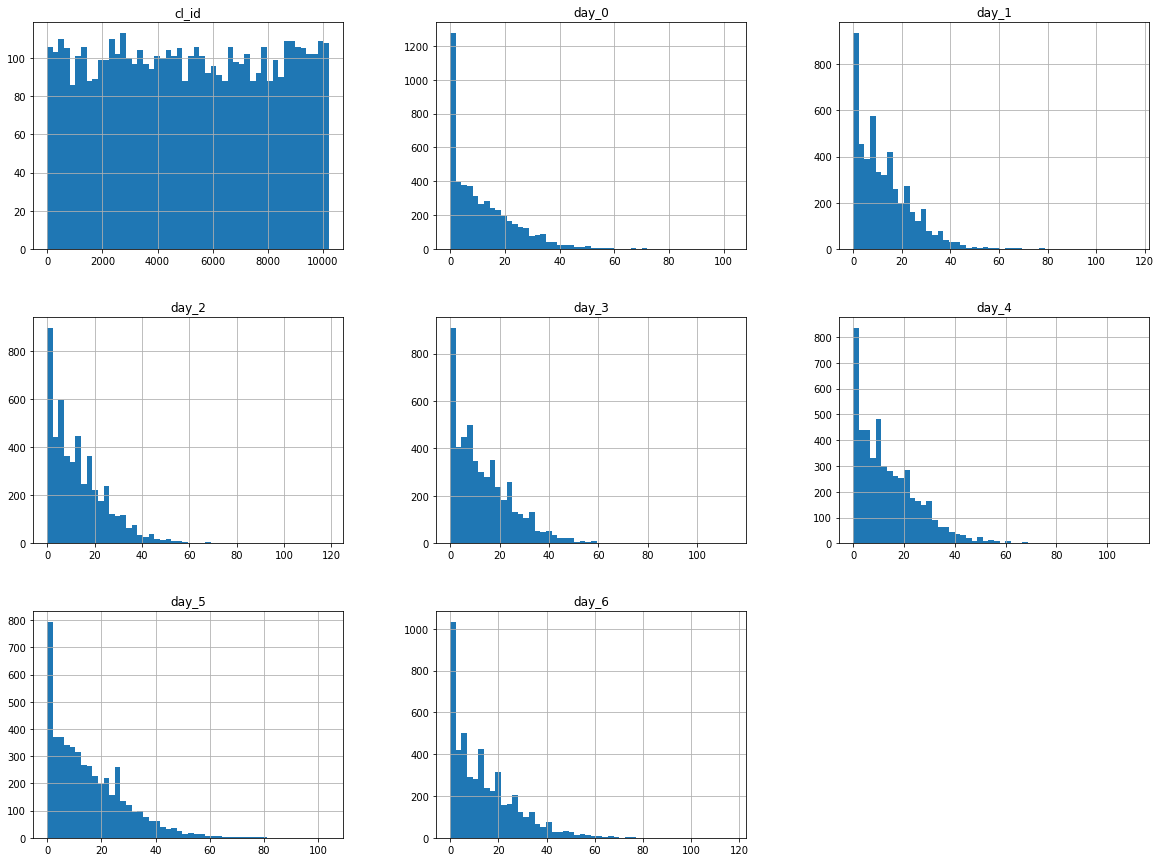

In [21]:
by_day_gr_count = transaction_by_day_count(raw_df)
by_day_gr_count.hist(bins=50, figsize=(20,15))

In [22]:
by_hour_gr_count = transaction_by_hour_count(raw_df)

In [23]:
by_hour_gr_sum = transaction_by_hour_sum(raw_df)

In [24]:
by_day_gr_sum = transaction_by_day_sum(raw_df)

In [25]:
days = [x for x in by_day_gr_count.columns.tolist() if x not in ['cl_id']]
days_data = by_day_gr_count.loc[:, days].sum().reset_index()

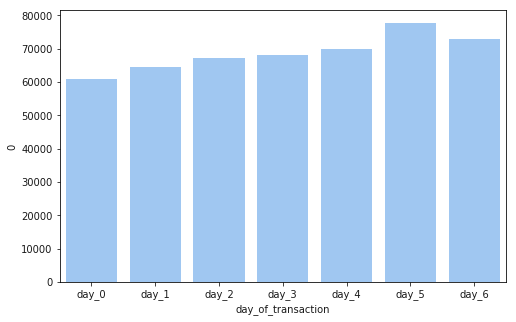

In [26]:
%config InlineBackend.figure_format = 'png'
f, ax = plt.subplots(figsize=(8, 5))
sns.set_color_codes("pastel")
sns.barplot(x="day_of_transaction", y=0, data=days_data,
            label="day_of_transaction", color="b")

In [27]:
days = [x for x in by_day_gr_sum.columns.tolist() if x not in ['cl_id']]
days_data = by_day_gr_sum.loc[:, days].sum().reset_index()

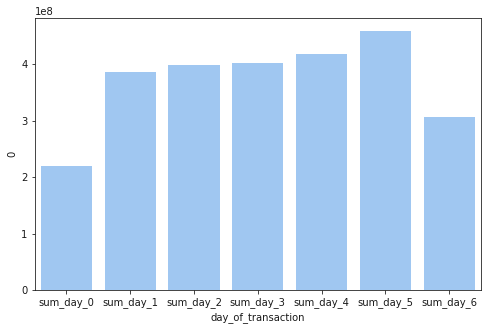

In [28]:
f, ax = plt.subplots(figsize=(8, 5))
sns.set_color_codes("pastel")
sns.barplot(x="day_of_transaction", y=0, data=days_data,
            label="day_of_transaction", color="b")

In [29]:
hours = [x for x in by_hour_gr_count.columns.tolist() if x not in ['cl_id']]
hours_data = by_hour_gr_count.loc[:, hours].sum().reset_index()

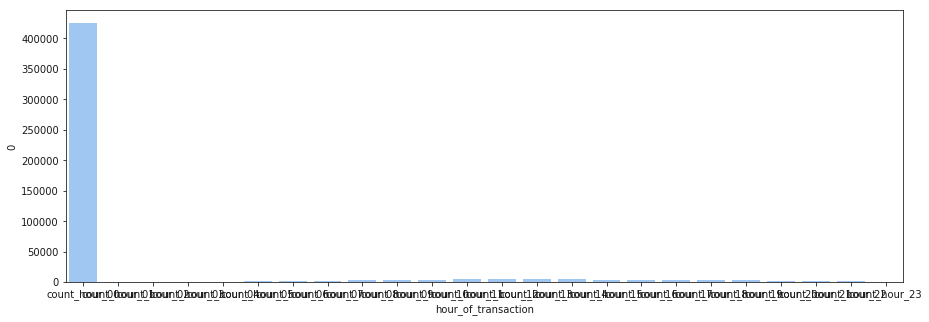

In [30]:
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="hour_of_transaction", y=0, data=hours_data,
            label="hour_of_transaction", color="b")

In [31]:
hours = [x for x in by_hour_gr_sum.columns.tolist() if x not in ['cl_id']]
hours_data = by_hour_gr_sum.loc[:, hours].sum().reset_index()

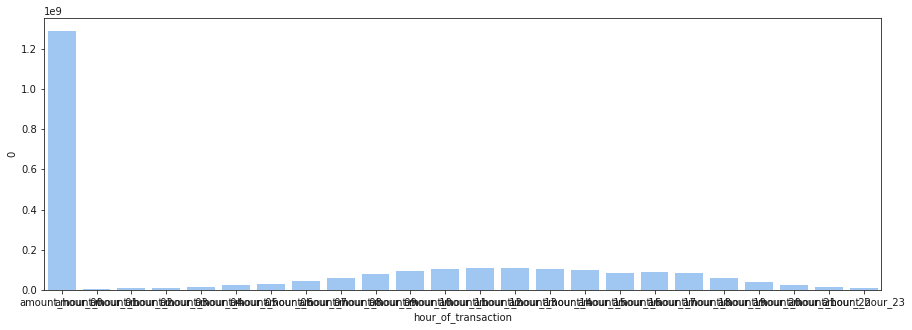

In [32]:
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="hour_of_transaction", y=0, data=hours_data,
            label="hour_of_transaction", color="b")

In [33]:
import sqlite3

In [34]:
conn = sqlite3.connect('transactions.db')

In [35]:
raw_df.to_sql('test_trans', if_exists = 'replace', con = conn)

In [36]:
check = pd.io.sql.read_sql("""
select * from test_trans limit 100
""", conn
)

In [37]:
raw_df.MCC.value_counts().head()

5411    120733
6011     53879
5814     41126
5812     29162
5499     26946
Name: MCC, dtype: int64

In [38]:
MCC_list = raw_df.MCC.value_counts().head(20).index.tolist()
for MCC_code in MCC_list: 
    print (
        'sum (case when MCC = {0} then amount else 0 end) as MCC_{1},'.format(MCC_code, MCC_code)
    )

sum (case when MCC = 5411 then amount else 0 end) as MCC_5411,
sum (case when MCC = 6011 then amount else 0 end) as MCC_6011,
sum (case when MCC = 5814 then amount else 0 end) as MCC_5814,
sum (case when MCC = 5812 then amount else 0 end) as MCC_5812,
sum (case when MCC = 5499 then amount else 0 end) as MCC_5499,
sum (case when MCC = 5541 then amount else 0 end) as MCC_5541,
sum (case when MCC = 5912 then amount else 0 end) as MCC_5912,
sum (case when MCC = 5999 then amount else 0 end) as MCC_5999,
sum (case when MCC = 6012 then amount else 0 end) as MCC_6012,
sum (case when MCC = 5921 then amount else 0 end) as MCC_5921,
sum (case when MCC = 5331 then amount else 0 end) as MCC_5331,
sum (case when MCC = 4829 then amount else 0 end) as MCC_4829,
sum (case when MCC = 5211 then amount else 0 end) as MCC_5211,
sum (case when MCC = 4121 then amount else 0 end) as MCC_4121,
sum (case when MCC = 5691 then amount else 0 end) as MCC_5691,
sum (case when MCC = 5261 then amount else 0 end) as MC

In [39]:
MCC_list = raw_df.MCC.value_counts().head(20).index.tolist()
for MCC_code in MCC_list: 
    print (
        'avg (case when MCC = {0} then amount else 0 end) as MCC_{1}_avg,'.format(MCC_code, MCC_code)
    )

avg (case when MCC = 5411 then amount else 0 end) as MCC_5411_avg,
avg (case when MCC = 6011 then amount else 0 end) as MCC_6011_avg,
avg (case when MCC = 5814 then amount else 0 end) as MCC_5814_avg,
avg (case when MCC = 5812 then amount else 0 end) as MCC_5812_avg,
avg (case when MCC = 5499 then amount else 0 end) as MCC_5499_avg,
avg (case when MCC = 5541 then amount else 0 end) as MCC_5541_avg,
avg (case when MCC = 5912 then amount else 0 end) as MCC_5912_avg,
avg (case when MCC = 5999 then amount else 0 end) as MCC_5999_avg,
avg (case when MCC = 6012 then amount else 0 end) as MCC_6012_avg,
avg (case when MCC = 5921 then amount else 0 end) as MCC_5921_avg,
avg (case when MCC = 5331 then amount else 0 end) as MCC_5331_avg,
avg (case when MCC = 4829 then amount else 0 end) as MCC_4829_avg,
avg (case when MCC = 5211 then amount else 0 end) as MCC_5211_avg,
avg (case when MCC = 4121 then amount else 0 end) as MCC_4121_avg,
avg (case when MCC = 5691 then amount else 0 end) as MCC_5691_

In [40]:
categories_list = raw_df.trx_category.value_counts().head(7).index.tolist()
for category in categories_list: 
    print (
        'sum (case when trx_category = \'{0}\' then amount else 0 end) as category_{1},'.format(category, category)
    )
for category in categories_list: 
    print (
        'avg (case when trx_category = \'{0}\' then amount else 0 end) as category_{1}_avg,'.format(category, category)
    )

sum (case when trx_category = 'POS' then amount else 0 end) as category_POS,
sum (case when trx_category = 'DEPOSIT' then amount else 0 end) as category_DEPOSIT,
sum (case when trx_category = 'WD_ATM_ROS' then amount else 0 end) as category_WD_ATM_ROS,
sum (case when trx_category = 'WD_ATM_PARTNER' then amount else 0 end) as category_WD_ATM_PARTNER,
sum (case when trx_category = 'C2C_IN' then amount else 0 end) as category_C2C_IN,
sum (case when trx_category = 'WD_ATM_OTHER' then amount else 0 end) as category_WD_ATM_OTHER,
sum (case when trx_category = 'C2C_OUT' then amount else 0 end) as category_C2C_OUT,
avg (case when trx_category = 'POS' then amount else 0 end) as category_POS_avg,
avg (case when trx_category = 'DEPOSIT' then amount else 0 end) as category_DEPOSIT_avg,
avg (case when trx_category = 'WD_ATM_ROS' then amount else 0 end) as category_WD_ATM_ROS_avg,
avg (case when trx_category = 'WD_ATM_PARTNER' then amount else 0 end) as category_WD_ATM_PARTNER_avg,
avg (case when tr

In [41]:
datamart_MCC_category =pd.io.sql.read_sql("""
select 
    cl_id,
    target_flag,
    channel_type,
    count(cl_id) as count,
    sum (amount) as sum_amount,
    avg (amount) as avg_amount,
    sum (case when MCC = 5411 then amount else 0 end) as MCC_5411,
    sum (case when MCC = 6011 then amount else 0 end) as MCC_6011,
    sum (case when MCC = 5814 then amount else 0 end) as MCC_5814,
    sum (case when MCC = 5812 then amount else 0 end) as MCC_5812,
    sum (case when MCC = 5499 then amount else 0 end) as MCC_5499,
    sum (case when MCC = 5541 then amount else 0 end) as MCC_5541,
    sum (case when MCC = 5912 then amount else 0 end) as MCC_5912,
    sum (case when MCC = 5999 then amount else 0 end) as MCC_5999,
    sum (case when MCC = 6012 then amount else 0 end) as MCC_6012,
    sum (case when MCC = 5921 then amount else 0 end) as MCC_5921,
    sum (case when MCC = 5331 then amount else 0 end) as MCC_5331,
    sum (case when MCC = 4121 then amount else 0 end) as MCC_4121,
    sum (case when MCC = 5211 then amount else 0 end) as MCC_5211,
    sum (case when MCC = 4829 then amount else 0 end) as MCC_4829,
    sum (case when MCC = 5691 then amount else 0 end) as MCC_5691,
    sum (case when MCC = 5261 then amount else 0 end) as MCC_5261,
    sum (case when MCC = 4111 then amount else 0 end) as MCC_4111,
    sum (case when MCC = 5977 then amount else 0 end) as MCC_5977,
    sum (case when MCC = 5200 then amount else 0 end) as MCC_5200,
    sum (case when MCC = 5732 then amount else 0 end) as MCC_5732,
/*------ avg ------- */
    avg (case when MCC = 5411 then amount else 0 end) as MCC_5411_avg,
    avg (case when MCC = 6011 then amount else 0 end) as MCC_6011_avg,
    avg (case when MCC = 5814 then amount else 0 end) as MCC_5814_avg,
    avg (case when MCC = 5812 then amount else 0 end) as MCC_5812_avg,
    avg (case when MCC = 5499 then amount else 0 end) as MCC_5499_avg,
    avg (case when MCC = 5541 then amount else 0 end) as MCC_5541_avg,
    avg (case when MCC = 5912 then amount else 0 end) as MCC_5912_avg,
    avg (case when MCC = 5999 then amount else 0 end) as MCC_5999_avg,
    avg (case when MCC = 6012 then amount else 0 end) as MCC_6012_avg,
    avg (case when MCC = 5921 then amount else 0 end) as MCC_5921_avg,
    avg (case when MCC = 5331 then amount else 0 end) as MCC_5331_avg,
    avg (case when MCC = 4121 then amount else 0 end) as MCC_4121_avg,
    avg (case when MCC = 5211 then amount else 0 end) as MCC_5211_avg,
    avg (case when MCC = 4829 then amount else 0 end) as MCC_4829_avg,
    avg (case when MCC = 5691 then amount else 0 end) as MCC_5691_avg,
    avg (case when MCC = 5261 then amount else 0 end) as MCC_5261_avg,
    avg (case when MCC = 4111 then amount else 0 end) as MCC_4111_avg,
    avg (case when MCC = 5977 then amount else 0 end) as MCC_5977_avg,
    avg (case when MCC = 5200 then amount else 0 end) as MCC_5200_avg,
    avg (case when MCC = 5732 then amount else 0 end) as MCC_5732_avg,
    sum (case when trx_category = 'POS' then amount else 0 end) as category_POS,
    sum (case when trx_category = 'DEPOSIT' then amount else 0 end) as category_DEPOSIT,
    sum (case when trx_category = 'WD_ATM_ROS' then amount else 0 end) as category_WD_ATM_ROS,
    sum (case when trx_category = 'WD_ATM_PARTNER' then amount else 0 end) as category_WD_ATM_PARTNER,
    sum (case when trx_category = 'C2C_IN' then amount else 0 end) as category_C2C_IN,
    sum (case when trx_category = 'WD_ATM_OTHER' then amount else 0 end) as category_WD_ATM_OTHER,
    sum (case when trx_category = 'C2C_OUT' then amount else 0 end) as category_C2C_OUT,
    avg (case when trx_category = 'POS' then amount else 0 end) as category_POS_avg,
    avg (case when trx_category = 'DEPOSIT' then amount else 0 end) as category_DEPOSIT_avg,
    avg (case when trx_category = 'WD_ATM_ROS' then amount else 0 end) as category_WD_ATM_ROS_avg,
    avg (case when trx_category = 'WD_ATM_PARTNER' then amount else 0 end) as category_WD_ATM_PARTNER_avg,
    avg (case when trx_category = 'C2C_IN' then amount else 0 end) as category_C2C_IN_avg,
    avg (case when trx_category = 'WD_ATM_OTHER' then amount else 0 end) as category_WD_ATM_OTHER_avg,
    avg (case when trx_category = 'C2C_OUT' then amount else 0 end) as category_C2C_OUT_avg
from test_trans 
group by 1, 2, 3
order by 1
""", conn
)

In [42]:
by_hour_gr_count.head()

hour_of_transaction,cl_id,count_hour_00,count_hour_01,count_hour_02,count_hour_03,count_hour_04,count_hour_05,count_hour_06,count_hour_07,count_hour_08,...,count_hour_14,count_hour_15,count_hour_16,count_hour_17,count_hour_18,count_hour_19,count_hour_20,count_hour_21,count_hour_22,count_hour_23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,299.0,3.0,6.0,8.0,14.0,9.0,18.0,17.0,12.0,...,6.0,3.0,3.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
# функции по группировке данных по частям суток

def group_midnight_count(row):
        return row.count_hour_00
def group_night_count(row):
        return row.count_hour_01+row.count_hour_02+row.count_hour_03+row.count_hour_04+row.count_hour_05+row.count_hour_06+row.count_hour_07
def group_morning_count(row):
        return row.count_hour_08+row.count_hour_09+row.count_hour_10+row.count_hour_11
def group_day_count(row):
        return row.count_hour_12+row.count_hour_13+row.count_hour_14+row.count_hour_13+row.count_hour_14+row.count_hour_15+row.count_hour_16+row.count_hour_17
def group_evening_count(row):
        return row.count_hour_18+row.count_hour_19+row.count_hour_20+row.count_hour_21+row.count_hour_22+row.count_hour_23

In [44]:
def group_midnight_amount(row):
        return row.amount_hour_00
def group_night_amount(row):
        return row.amount_hour_01+row.amount_hour_02+row.amount_hour_03+row.amount_hour_04+row.amount_hour_05+row.amount_hour_06+row.amount_hour_07
def group_morning_amount(row):
        return row.amount_hour_08+row.amount_hour_09+row.amount_hour_10+row.amount_hour_11
def group_day_amount(row):
        return row.amount_hour_12+row.amount_hour_13+row.amount_hour_14+row.amount_hour_13+row.amount_hour_14+row.amount_hour_15+row.amount_hour_16+row.amount_hour_17
def group_evening_amount(row):
        return row.amount_hour_18+row.amount_hour_19+row.amount_hour_20+row.amount_hour_21+row.amount_hour_22+row.amount_hour_23

In [45]:
by_hour_gr_count['midnight_count'] = by_hour_gr_count.apply(group_midnight_count, axis = 1)
by_hour_gr_count['night_count'] = by_hour_gr_count.apply(group_night_count, axis = 1)
by_hour_gr_count['morning_count'] = by_hour_gr_count.apply(group_morning_count, axis = 1)
by_hour_gr_count['day_count'] = by_hour_gr_count.apply(group_day_count, axis = 1)
by_hour_gr_count['evening_count'] = by_hour_gr_count.apply(group_evening_count, axis = 1)

In [46]:
by_hour_gr_sum['midnight_amount'] = by_hour_gr_sum.apply(group_midnight_amount, axis = 1)
by_hour_gr_sum['night_amount'] = by_hour_gr_sum.apply(group_night_amount, axis = 1)
by_hour_gr_sum['morning_amount'] = by_hour_gr_sum.apply(group_morning_amount, axis = 1)
by_hour_gr_sum['day_amount'] = by_hour_gr_sum.apply(group_day_amount, axis = 1)
by_hour_gr_sum['evening_amount'] = by_hour_gr_sum.apply(group_evening_amount, axis = 1)

In [47]:
by_day_gr_sum.head()

day_of_transaction,cl_id,sum_day_0,sum_day_1,sum_day_2,sum_day_3,sum_day_4,sum_day_5,sum_day_6
0,0,0.000,0.000,37329.0000,0.000,20000.0000,0.0000,7054.0000
1,1,107811.220,24146.624,72663.6478,9400.618,14769.3784,21083.7674,83522.3902
2,5,55804.756,36018.810,168912.8100,45179.360,101601.7500,64274.6800,62999.4094
3,9,2306.090,385400.000,152659.0000,10500.000,210350.0000,87500.0000,600.0000
4,10,382397.790,42844.640,99454.1700,40553.220,61346.6200,48418.0400,411634.5300


In [48]:
def group_weekends_count(row):
        return row.day_0+row.day_6
def group_workdays_count(row):
        return row.day_1+row.day_2+row.day_3+row.day_4+row.day_5
def group_weekends_sum(row):
        return row.sum_day_0+row.sum_day_6
def group_workdays_sum(row):
        return row.sum_day_1+row.sum_day_2+row.sum_day_3+row.sum_day_4+row.sum_day_5

In [49]:
by_day_gr_count['weekends_count'] = by_day_gr_count.apply(group_weekends_count, axis=1)
by_day_gr_count['workdays_count'] = by_day_gr_count.apply(group_workdays_count, axis=1)

In [50]:
by_day_gr_sum['weekends_sum'] = by_day_gr_sum.apply(group_weekends_sum, axis=1)
by_day_gr_sum['workdays_sum'] = by_day_gr_sum.apply(group_workdays_sum, axis=1)

In [51]:
by_day_gr_count = by_day_gr_count.loc[:, ['cl_id','weekends_count', 'workdays_count']]

In [52]:
by_day_gr_sum = by_day_gr_sum.loc[:, ['cl_id','weekends_sum', 'workdays_sum']]

In [53]:
by_hour_gr_count = by_hour_gr_count.loc[:, ['cl_id','midnight_count', 'night_count', 'morning_count', 'day_count', 'evening_count']]

In [54]:
by_hour_gr_sum = by_hour_gr_sum.loc[:, ['cl_id','midnight_amount', 'night_amount', 'morning_amount', 'day_amount', 'evening_amount']]

In [55]:
df = datamart_MCC_category.merge(by_day_gr_count, how='left', on = 'cl_id')

In [56]:
df = df.fillna('na')

In [57]:
df = df.merge(by_day_gr_sum, how='left', on = 'cl_id')

In [58]:
df = df.merge(by_hour_gr_count, how='left', on = 'cl_id')

In [59]:
df = df.merge(by_hour_gr_sum, how='left', on = 'cl_id')
df.head()

,cl_id,target_flag,channel_type,count,sum_amount,avg_amount,MCC_5411,MCC_6011,MCC_5814,MCC_5812,...,midnight_count,night_count,morning_count,day_count,evening_count,midnight_amount,night_amount,morning_amount,day_amount,evening_amount
0,0,0,na,5,6.438300e+04,12876.600000,2031.0000,20000.0,0.00,0.0000,...,3.0,0.0,0.0,3.0,0.0,7821.0000,0.00,0.0,93124.00,0.00
1,1,0,na,104,3.333976e+05,3205.746594,20246.6376,145000.0,82441.17,39180.6738,...,101.0,0.0,0.0,0.0,3.0,188397.6458,0.00,0.0,0.00,145000.00
2,5,1,na,137,5.347916e+05,3903.588142,46877.9294,208000.0,247.00,3309.0000,...,119.0,0.0,2.0,12.0,7.0,338291.5754,0.00,7000.0,116000.00,86000.00
3,9,0,na,39,8.493151e+05,21777.310000,39.0000,540000.0,0.00,0.0000,...,7.0,8.0,8.0,10.0,7.0,402409.0000,800.00,180900.0,261100.00,4406.09
4,10,0,na,460,1.086649e+06,2362.280457,53920.3600,854000.0,2010.00,319.0000,...,299.0,75.0,35.0,63.0,1.0,198587.8800,107923.47,380380.0,422287.66,100.00


In [60]:
# строим корреляционную матрицу и находим корреляцию с таргетом

corr_matrix = df.corr()
corr =  corr_matrix['target_flag'].sort_values(ascending=False) 
corr

target_flag                    1.000000
count                          0.244709
midnight_count                 0.242665
workdays_count                 0.239306
weekends_count                 0.224254
category_POS                   0.190951
MCC_5814                       0.170083
MCC_5812                       0.141029
MCC_5411                       0.127866
weekends_sum                   0.122178
MCC_5691                       0.109226
category_WD_ATM_OTHER          0.100509
midnight_amount                0.094084
day_count                      0.091459
sum_amount                     0.084506
night_count                    0.079881
MCC_5912                       0.075937
MCC_5814_avg                   0.074115
MCC_5541                       0.072848
MCC_4121                       0.069082
MCC_5999                       0.067046
MCC_5921                       0.062054
workdays_sum                   0.061681
morning_count                  0.057060
evening_count                  0.052346


In [61]:
# сортируем по квадрату корреляции для отбора признаков

corr_d = corr.to_dict()
for x in corr_d:
    corr_d[x] = corr_d[x]**2
top10 = sorted(corr_d.values())[1::1]
r2sorted = []
for x in top10:
    for i in corr_d:
        if corr_d[i] == x:
            r2sorted.append(i)
len(r2sorted)

72

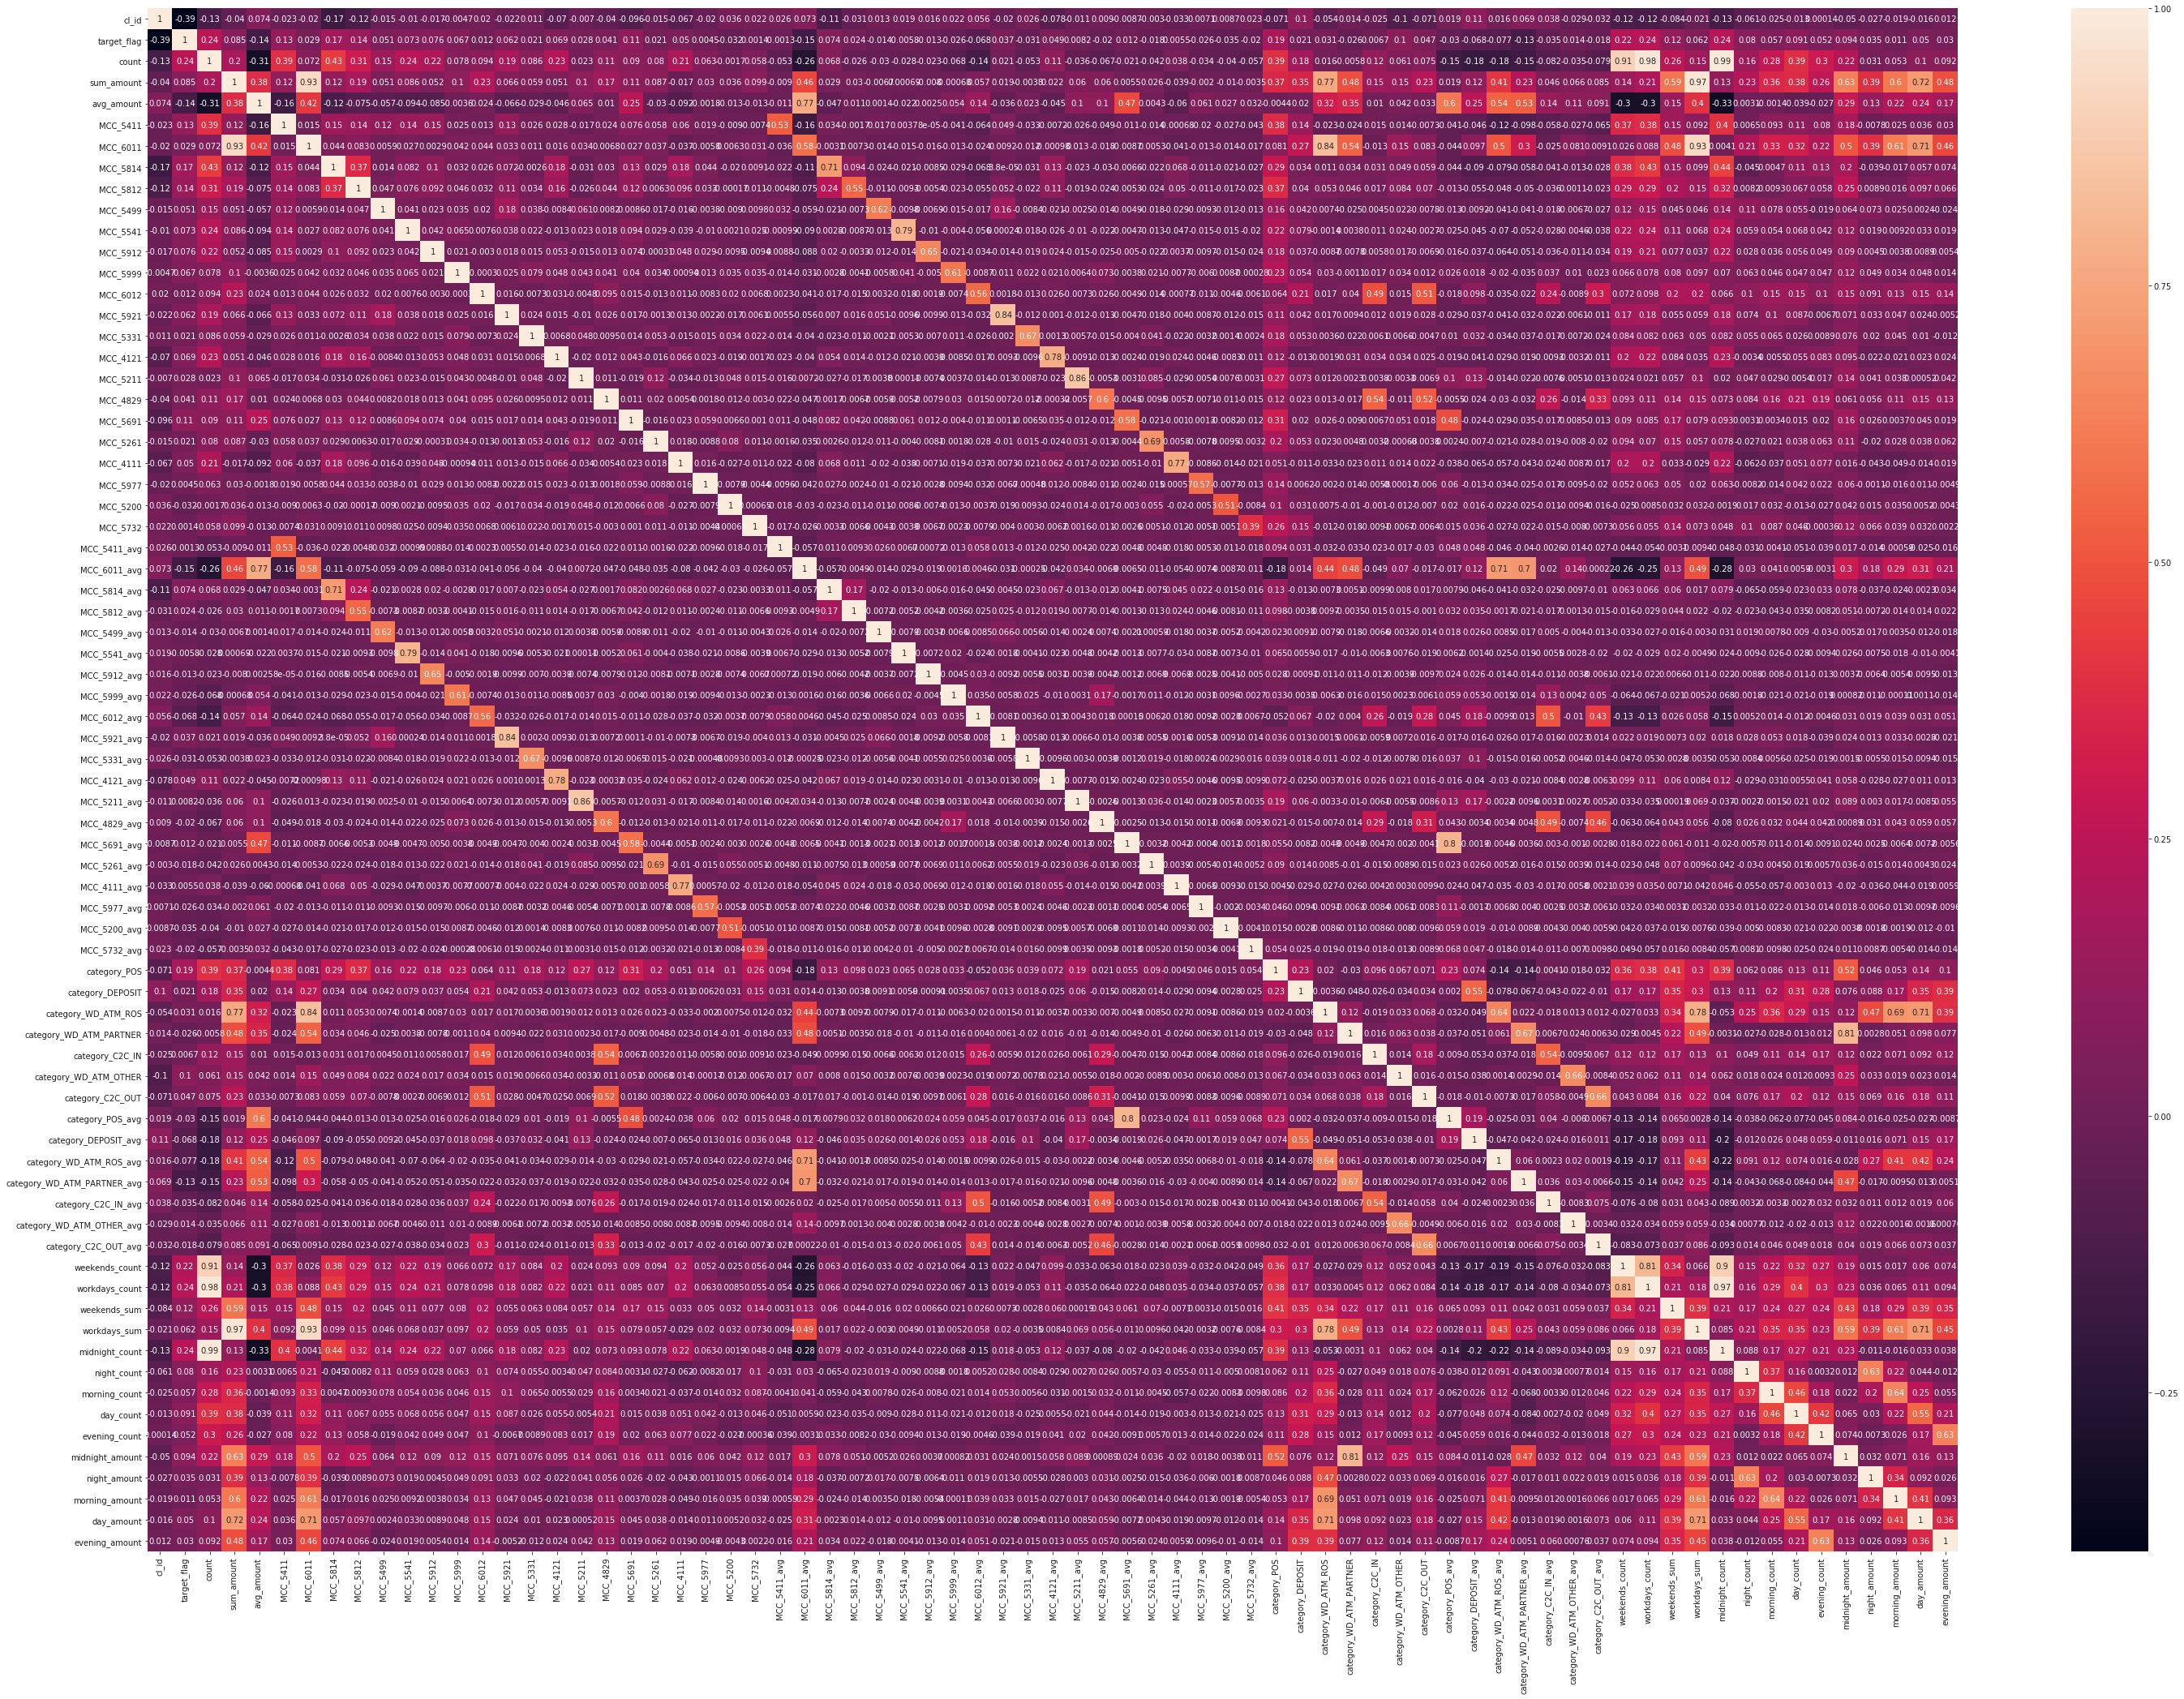

In [62]:
plt.subplots(figsize=(50,35))
sns.heatmap(corr_matrix, annot=True,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

In [63]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [64]:
df = get_one_hot(df, ['channel_type'])
df.head()

,cl_id,target_flag,channel_type,count,sum_amount,avg_amount,MCC_5411,MCC_6011,MCC_5814,MCC_5812,...,night_amount,morning_amount,day_amount,evening_amount,channel_type_na,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,0,0,na,5,6.438300e+04,12876.600000,2031.0000,20000.0,0.00,0.0000,...,0.00,0.0,93124.00,0.00,1,0,0,0,0,0
1,1,0,na,104,3.333976e+05,3205.746594,20246.6376,145000.0,82441.17,39180.6738,...,0.00,0.0,0.00,145000.00,1,0,0,0,0,0
2,5,1,na,137,5.347916e+05,3903.588142,46877.9294,208000.0,247.00,3309.0000,...,0.00,7000.0,116000.00,86000.00,1,0,0,0,0,0
3,9,0,na,39,8.493151e+05,21777.310000,39.0000,540000.0,0.00,0.0000,...,800.00,180900.0,261100.00,4406.09,1,0,0,0,0,0
4,10,0,na,460,1.086649e+06,2362.280457,53920.3600,854000.0,2010.00,319.0000,...,107923.47,380380.0,422287.66,100.00,1,0,0,0,0,0


In [65]:
df.drop(columns=['channel_type'], axis = 1, inplace = True)

In [66]:
np.random.seed = 45
cl_ids_test = np.random.choice(df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [67]:
# create transactions dataset for train
df_train = df[~df.cl_id.isin(cl_ids_test)].copy()
print("Total clients in train dataset: ", len(df_train))
# create transactions dataset for test
df_test = df[df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(df_test))
df_train.head()

Total clients in train dataset:  3999
Total transactions in test dataset:  1000


,cl_id,target_flag,count,sum_amount,avg_amount,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,...,night_amount,morning_amount,day_amount,evening_amount,channel_type_na,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,0,0,5,64383.0000,12876.600000,2031.0000,20000.0,0.00,0.0000,0.000,...,0.0,0.0,93124.0,0.00,1,0,0,0,0,0
1,1,0,104,333397.6458,3205.746594,20246.6376,145000.0,82441.17,39180.6738,1221.724,...,0.0,0.0,0.0,145000.00,1,0,0,0,0,0
3,9,0,39,849315.0900,21777.310000,39.0000,540000.0,0.00,0.0000,0.000,...,800.0,180900.0,261100.0,4406.09,1,0,0,0,0,0
5,11,0,217,434016.6302,2000.076637,31084.6200,182000.0,5653.00,14046.2000,1804.258,...,0.0,0.0,192000.0,30000.00,1,0,0,0,0,0
6,14,1,136,448690.1700,3299.192426,20408.9600,37000.0,23894.06,5659.0000,827.000,...,0.0,37000.0,288000.0,8700.00,1,0,0,0,0,0


In [68]:
from sklearn.feature_selection import VarianceThreshold

In [69]:
train_columns = [
col for col in df_train.columns.tolist()
if col not in set(
    [
    'target_flag',
    r2sorted[0],
    r2sorted[1],
    r2sorted[4],
    r2sorted[5],
    r2sorted[7],
    r2sorted[8],
    r2sorted[10],
    r2sorted[11],
    r2sorted[13],
    r2sorted[14],
    r2sorted[16],
    r2sorted[18],
    r2sorted[19],
    r2sorted[21],
    r2sorted[23],
    r2sorted[35],
    r2sorted[36],
    r2sorted[71],
    ]
        )
        ]
x_train = df_train[train_columns]
y_train = df_train['target_flag']
x_test = df_test[train_columns]
y_test = df_test['target_flag']
x_train.head()

,cl_id,count,sum_amount,avg_amount,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_5541,...,night_amount,morning_amount,day_amount,evening_amount,channel_type_na,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,0,5,64383.0000,12876.600000,2031.0000,20000.0,0.00,0.0000,0.000,0.00,...,0.0,0.0,93124.0,0.00,1,0,0,0,0,0
1,1,104,333397.6458,3205.746594,20246.6376,145000.0,82441.17,39180.6738,1221.724,0.00,...,0.0,0.0,0.0,145000.00,1,0,0,0,0,0
3,9,39,849315.0900,21777.310000,39.0000,540000.0,0.00,0.0000,0.000,0.00,...,800.0,180900.0,261100.0,4406.09,1,0,0,0,0,0
5,11,217,434016.6302,2000.076637,31084.6200,182000.0,5653.00,14046.2000,1804.258,5672.70,...,0.0,0.0,192000.0,30000.00,1,0,0,0,0,0
6,14,136,448690.1700,3299.192426,20408.9600,37000.0,23894.06,5659.0000,827.000,979.65,...,0.0,37000.0,288000.0,8700.00,1,0,0,0,0,0


In [70]:
y = df_train.target_flag
X = df_train.drop('target_flag', axis=1)
y_test = df_test.target_flag
X_test = df_test.drop('target_flag', axis=1)

In [71]:
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

In [72]:
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X)
X_test_minmax = min_max_scaler.fit_transform(X_test)

In [73]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_minmax, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [74]:
y_train_predict = lin_reg.predict(X_train_minmax)
y_test_predict = lin_reg.predict(X_test_minmax)

In [75]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.7872
Test:  0.6685


In [76]:
xgb = xgboost.XGBClassifier(max_depth=5, random_seed = 42, n_jobs=10)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]

In [77]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.963
Test:  0.83


In [78]:
# В лидерборде соревнования 150 место

In [79]:
import catboost
from catboost import *

In [80]:
cat_features = list(range(0, X.shape[1]))

In [81]:
col = [x for x in X.columns if x not in ['cl_id', 'count']]

In [82]:
# перекодируем все переменные в str по требованию catboost
for i in col:
    X[i] = X[i].astype('str')

In [83]:
for i in col:
    X_test[i] = X_test[i].astype('str')

In [84]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [86]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    eval_metric='AUC',
    iterations=100,
    random_seed=42,
    learning_rate=0.2,
    use_best_model=True, #---- параметр обрезает ненужные итерации (выбирает лучшую модель)
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
y_train_predict = model.predict_proba(data=X_train)[:, 1]
y_test_predict = model.predict_proba(data = X_test)[:, 1]

In [88]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.711
Test:  0.8075


In [89]:
import lightgbm

In [90]:
col = [x for x in X.columns if x not in ['cl_id', 'count']]

In [91]:
for i in col:
    X_validation[i] = X_validation[i].astype('float')

/home/pavel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [92]:
for i in col:
    X_train[i] = X_train[i].astype('float')

/home/pavel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [93]:
for i in col:
    X_test[i] = X_test[i].astype('float')

In [94]:
X_train = X_train[train_columns]
X_test = X_test[train_columns]
X_validation = X_validation[train_columns]

In [95]:
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_validation, label=y_validation)

In [96]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [97]:
light_class = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.753866
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.771522
[3]	valid_0's auc: 0.781053
[4]	valid_0's auc: 0.788356
[5]	valid_0's auc: 0.792138
[6]	valid_0's auc: 0.796439
[7]	valid_0's auc: 0.796511
[8]	valid_0's auc: 0.799194
[9]	valid_0's auc: 0.800442
[10]	valid_0's auc: 0.799976
[11]	valid_0's auc: 0.802288
[12]	valid_0's auc: 0.804743
[13]	valid_0's auc: 0.804555
[14]	valid_0's auc: 0.805603
[15]	valid_0's auc: 0.806138
[16]	valid_0's auc: 0.803592
[17]	valid_0's auc: 0.803886
[18]	valid_0's auc: 0.805356
[19]	valid_0's auc: 0.804974
[20]	valid_0's auc: 0.805281
[21]	valid_0's auc: 0.804799
[22]	valid_0's auc: 0.805037
[23]	valid_0's auc: 0.805775
[24]	valid_0's auc: 0.804937
[25]	valid_0's auc: 0.804061
[26]	valid_0's auc: 0.805606
[27]	valid_0's auc: 0.807358
[28]	valid_0's auc: 0.807264
[29]	valid_0's auc: 0.806513
[30]	valid_0's auc: 0.806319
[31]	valid_0's auc: 0.807145
[32]	valid_0's auc: 0.805781
[33]	valid_0's auc

In [98]:
y_train_predict = light_class.predict(data=X_train)

In [99]:
y_test_predict = light_class.predict(data=X_test)

In [100]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.9208
Test:  0.8288
